In [0]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [2]:
import tensorflow as tf
print(tf.__version__)

2.2.0


In [0]:
import numpy as np
import matplotlib.pyplot as plt
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

In [4]:
!wget --no-check-certificate \
    https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv \
    -O /tmp/daily-min-temperatures.csv

--2020-05-26 09:21:59--  https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 67921 (66K) [text/plain]
Saving to: ‘/tmp/daily-min-temperatures.csv’

/tmp/daily-min-temp 100%[===================>]  66.33K  --.-KB/s    in 0.01s   

2020-05-26 09:21:59 (5.56 MB/s) - ‘/tmp/daily-min-temperatures.csv’ saved [67921/67921]



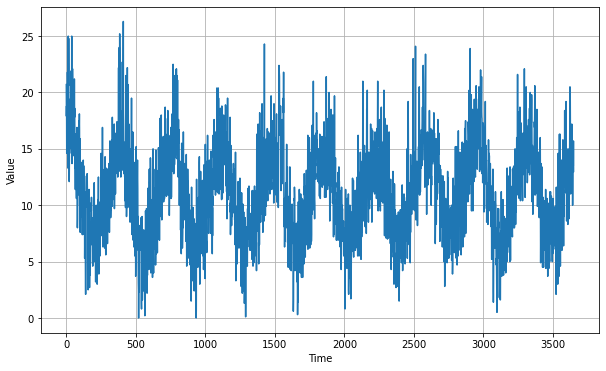

In [5]:
import csv
time_step = []
temps = []

with open('/tmp/daily-min-temperatures.csv') as csvfile:
  reader = csv.reader(csvfile, delimiter= ',')
  next(reader)
  step_for_time_step =0
  for row in reader:
    time_step.append(step_for_time_step)
    temps.append(float(row[1]))
    step_for_time_step +=1
    
# YOUR CODE HERE. READ TEMPERATURES INTO TEMPS
# HAVE TIME STEPS BE A SIMPLE ARRAY OF 1, 2, 3, 4 etc

series = np.array(temps)
time = np.array(time_step)
plt.figure(figsize=(10, 6))
plot_series(time, series)

In [0]:
split_time = 2500
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 30
batch_size = 32
shuffle_buffer_size = 1000


In [0]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    # YOUR CODE HERE
    series = tf.expand_dims(series,axis=-1 )
    ds = tf.data.Dataset.from_tensor_slices( series )
    ds = ds.window( size = window_size+1 , shift =1, stride=1, drop_remainder = True)
    ds = ds.flat_map( lambda w : w.batch(window_size+1))
    ds = ds.map( lambda w: (w[:-1], w[-1:]))
    ds = ds.shuffle(buffer_size = shuffle_buffer, seed=None, reshuffle_each_iteration=None)
    return ds.batch(batch_size).prefetch(1)


In [0]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [9]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
window_size = 64
batch_size = 256
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(train_set)
print(x_train.shape)

model = tf.keras.models.Sequential([
# YOUR CODE HERE
  tf.keras.layers.Conv1D(filters=32, kernel_size=5, strides=1, padding='causal', activation='relu', input_shape=[None,1] ),
  tf.keras.layers.LSTM(64,return_sequences=True),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.Dense(30,activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x*400)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch : 1e-8 * 100**(epoch/20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum =0.9)
model.compile(loss = tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks = [lr_schedule])

<PrefetchDataset shapes: ((None, None, 1), (None, None, 1)), types: (tf.float64, tf.float64)>
(2500,)
Epoch 1/100
10/10 [==============================] - 1s 52ms/step - loss: 31.1418 - mae: 31.6401 - lr: 1.0000e-08
Epoch 2/100
10/10 [==============================] - 0s 43ms/step - loss: 30.5497 - mae: 31.0479 - lr: 1.2589e-08
Epoch 3/100
10/10 [==============================] - 0s 44ms/step - loss: 29.5563 - mae: 30.0543 - lr: 1.5849e-08
Epoch 4/100
10/10 [==============================] - 0s 46ms/step - loss: 28.1686 - mae: 28.6663 - lr: 1.9953e-08
Epoch 5/100
10/10 [==============================] - 0s 47ms/step - loss: 26.2244 - mae: 26.7218 - lr: 2.5119e-08
Epoch 6/100
10/10 [==============================] - 0s 47ms/step - loss: 23.3767 - mae: 23.8734 - lr: 3.1623e-08
Epoch 7/100
10/10 [==============================] - 0s 43ms/step - loss: 19.1992 - mae: 19.6948 - lr: 3.9811e-08
Epoch 8/100
10/10 [==============================] - 0s 49ms/step - loss: 13.6423 - mae: 14.1348 - l

(1e-08, 0.0001, 0.0, 60.0)

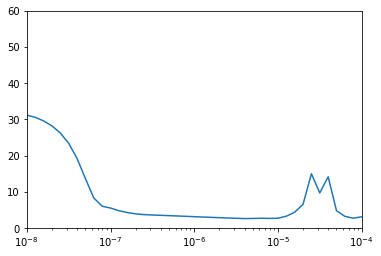

In [10]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 60])

In [16]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
train_set = windowed_dataset(x_train, window_size=60, batch_size=100, shuffle_buffer=shuffle_buffer_size)
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=60, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])


optimizer = tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set,epochs=150)
                                    
# EXPECTED OUTPUT SHOULD SEE AN MAE OF <2 WITHIN ABOUT 30 EPOCHS

Epoch 1/150
25/25 [==============================] - 1s 31ms/step - loss: 9.8779 - mae: 10.3645
Epoch 2/150
25/25 [==============================] - 1s 31ms/step - loss: 2.7307 - mae: 3.1968
Epoch 3/150
25/25 [==============================] - 1s 31ms/step - loss: 2.4405 - mae: 2.9030
Epoch 4/150
25/25 [==============================] - 1s 31ms/step - loss: 2.3559 - mae: 2.8171
Epoch 5/150
25/25 [==============================] - 1s 31ms/step - loss: 2.4623 - mae: 2.9244
Epoch 6/150
25/25 [==============================] - 1s 30ms/step - loss: 2.3702 - mae: 2.8316
Epoch 7/150
25/25 [==============================] - 1s 31ms/step - loss: 2.3196 - mae: 2.7793
Epoch 8/150
25/25 [==============================] - 1s 31ms/step - loss: 2.4255 - mae: 2.8877
Epoch 9/150
25/25 [==============================] - 1s 30ms/step - loss: 2.2868 - mae: 2.7469
Epoch 10/150
25/25 [==============================] - 1s 31ms/step - loss: 2.2917 - mae: 2.7511
Epoch 11/150
25/25 [============================

In [0]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

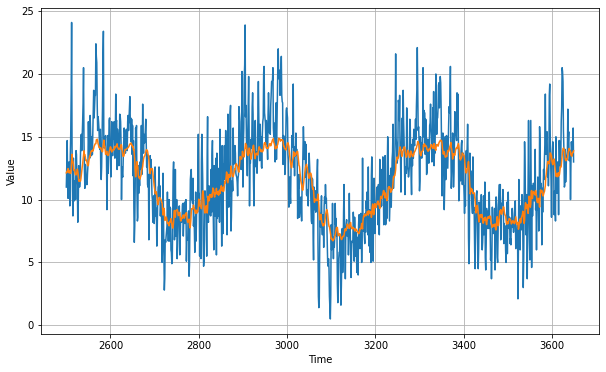

In [18]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

# EXPECTED OUTPUT. PLOT SHOULD SHOW PROJECTIONS FOLLOWING ORIGINAL DATA CLOSELY

In [19]:
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

# EXPECTED OUTPUT MAE < 2 -- I GOT 1.789626

2.037951

In [20]:
print(rnn_forecast)
# EXPECTED OUTPUT -- ARRAY OF VALUES IN THE LOW TEENS

[12.128184 12.236918 12.193443 ... 13.760187 13.751012 13.882695]
